# Table of contents

[Regression](#regression)

[Regression model null model p-value distribution](#regression_pval)

[linear MC regression](#MC_regression)

[log MC regression](#log_MC_regression)

[Comparison between $\beta$ mean removal](#beta_mean_removal)

[Models comparison](#models_comp)


In [1287]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import fine_time_coupling_samples
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import allensdk
import h5py
import pynwb
import hdmf
import matplotlib
print('pd', pd.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.3.2


In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

### Neurons Selection

In [5]:
probes = ['probeC', 'probeD', 'probeE'] # ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

# Fine Time Coupling Model <a name="coupling_model"></a>

In [6]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)

## Trials Selection

#### drifting gratings

In [8]:
orientation = [180, 225., 270.]  # 'null'
temporal_frequency = [4., 8.]  # 'null'
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[
    stimulus_table['orientation'].isin(orientation) & 
    stimulus_table['temporal_frequency'].isin(temporal_frequency)]

all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
model.print_conditions(trials_groups)

0  258 [4.0] [225.0] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
1  259 [4.0] [270.0] [ 3815  3832  3851  3893  3910  3969 31009 31140 31189 49221 49243 49252 49303 49314 49385]
2  269 [4.0] [180.0] [ 3834  3945 31045 31082 31134 31139 31141 49218 49235 49236 49237 49246 49259 49306 49326]
3  278 [8.0] [225.0] [ 3866  3878  3925  3937  3984 31142 31159 31174 31194 49290 49307 49374 49390 49401 49418]
4  280 [8.0] [270.0] [ 3872  3900  3905  3946  3956  3980 31021 31046 31064 31080 31173 31182 31188 49211 49225]
5  286 [8.0] [180.0] [ 3933  3949  3962 31154 31165 31177 31187 31199 49226 49228 49240 49280 49328 49332 49405]
total num trials: 90


In [118]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261,
#                  278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261,
#                  286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989

In [7]:
condition_ids = [268, 270]
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  268 temp freq [4.0] orient [45.0] contrast [0.8] [ 3833  3882  3884  3899  3951  3988 31040 31086 31089 31116 31149 31197 49255 49277 49327]
1  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 49415 49422]
total num trials: 30


## Spike Trains

In [8]:
trial_time_window=[0.0, 2.0]
dt=0.002
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)

# spike_trains = model.get_trial_metric_per_unit_per_trial(
#     stimulus_presentation_ids=all_trials_indices,
#     unit_ids=selected_units.index.values,
#     trial_time_window=trial_time_window,
#     metric_type='spike_trains', dt=dt)
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_times')


In [9]:
# display(spike_trains.shape)
# display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(261, 30)

# linear regression model <a name="regression"></a>

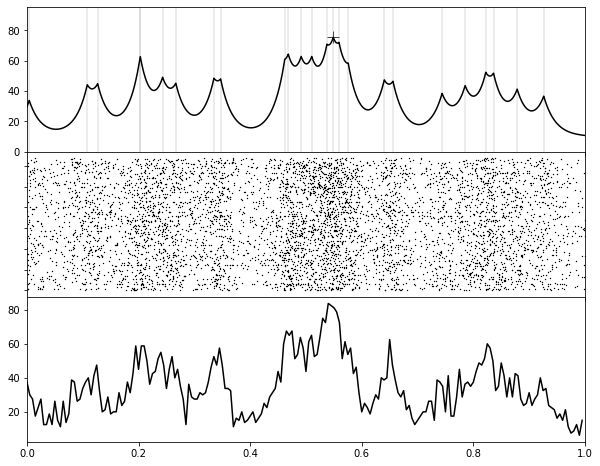

In [1285]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)
trial_length = 1
num_peaks = 25
num_trials = 80
sigma = 0.03
spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=True)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]

synchrony_rate = 2
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

# synchrony_prob= 0.01
# spike_times_sync_x, spike_times_sync_y = generator.inject_prob_synchrony_to_spike_times(
#     spike_times_x, spike_times_y, synchrony_prob, trial_length)

num iterations:  163
[[0.58165539]]
overall mean FR: 37.35
estimat mean FR: 21.81


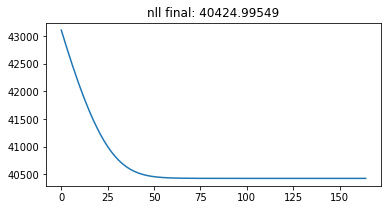

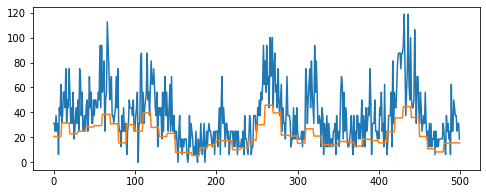

In [348]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02
link_func='linear'

jittertool.bivariate_spike_hist_coupling_filter_regression(spike_times_sync_x, spike_times_sync_y, link_func=link_func,
        trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width)

# Regression model null model p-value distribution. <a name="regression_pval"></a>

#### Homo Poisson

In [77]:
jittertool = jitter.JitterTool()
generator = hierarchical_model_generator.HierarchicalModelGenerator()

length = 1
lmbd_0 = 20
lmbd_1 = 20
num_iters = 200
num_trials=25

jitter_window_width = 0.04
spk_bin_width = 0.002
basis_type = 'B0B1'

p_vals_list = np.zeros(num_iters)

for r in trange(num_iters):
    spike_times_x = generator.generate_poisson_spike_times(lmbd_0, length, num_trials=num_trials)
    spike_times_y = generator.generate_poisson_spike_times(lmbd_1, length, num_trials=num_trials)

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_lrt(spike_times_x, spike_times_y,
        trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width,
        epsilon=1e-7, basis_type=basis_type)


D:/Brain_Network/Code\jitter.py:1607: UserWarning: Reach max iterations. Last err:1.289e-07
  warnings.warn(f'Reach max iterations. Last err:{beta_err:.3e}')


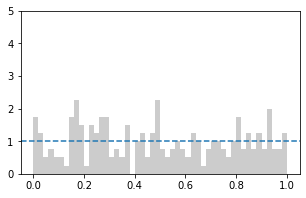

In [79]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02, ylim=[0,5])

#### Mixture of Laplace

In [391]:
jittertool = jitter.JitterTool()
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

num_iters = 200
num_trials = 50
trial_length = 2
num_peaks = 25
sigma = 0.03

jitter_window_width = 0.025
spk_bin_width = 0.001
basis_type = 'B0B1'

p_vals_list = np.zeros(num_iters)

for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_lrt(spike_times_x, spike_times_y,
            trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width,
            basis_type=basis_type, epsilon=1e-4, cache_parameters=True)


In [ ]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02, ylim=[0, 5])

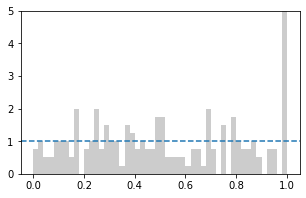

In [393]:
# epsilon=1e-4  The selection of the convergence threshold does matter.

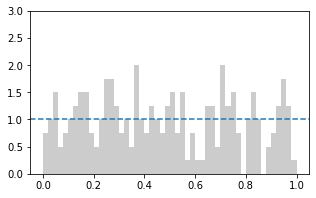

In [390]:
# epsilon=1e-6

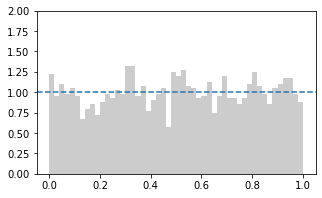

In [134]:
# num_iters = 2000
# num_trials = 25
# trial_length = 1
# num_peaks = 25
# sigma = 0.04
# jitter_window_width = 0.02
# spk_bin_width = 0.002

In [ ]:
file_path = 'D:/Brain_Network/Output/models/jitter/regression_lambda_laplace_null_p_vals.pkl'
# util.save_variable(file_path, p_vals_list)

#### Spike centered regression, jitter type = 'basic'

In [329]:
jittertool = jitter.JitterTool()
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

num_iters = 2000
num_trials = 25
trial_length = 1
num_peaks = 25
sigma = 0.03

jitter_window_width = 0.02
spk_bin_width = 0.002

p_vals_list = np.zeros(num_iters)

for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_lrt(spike_times_x, spike_times_y,
            trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width,
            jitter_type='basic')


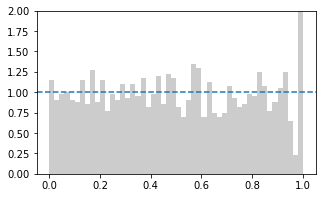

In [330]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02)

#### For a narrow mixture of Laplace.

In [158]:
jittertool = jitter.JitterTool()
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

num_iters = 2000
num_trials = 25
trial_length = 1
num_peaks = 25
sigma = 0.01

jitter_window_width = 0.04
spk_bin_width = 0.002

p_vals_list = np.zeros(num_iters)

for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_lrt(spike_times_x, spike_times_y,
            trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width)


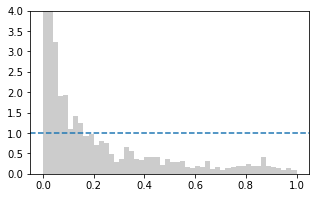

In [161]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02, ylim=[0,4])

In [163]:
file_path = 'D:/Brain_Network/Output/models/jitter/regression_lambda_narrow_laplace_p_vals.pkl'
# util.save_variable(file_path, p_vals_list)

util.save_variable, save variable to:  D:/Brain_Network/Output/models/jitter/regression_lambda_narrow_laplace_p_vals.pkl


#### regression without jitter correction.

In [299]:
jittertool = jitter.JitterTool()
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

num_iters = 200
num_trials = 25
trial_length = 1
num_peaks = 25
sigma = 0.03

jitter_window_width = 0.04
spk_bin_width = 0.002
basis_type = 'B0B1'

p_vals_list = np.zeros(num_iters)

for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_lrt(spike_times_x, spike_times_y,
            trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width,
            basis_type=basis_type, cache_parameters=True)

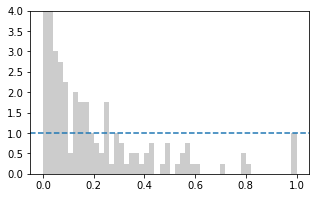

In [301]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02, ylim=[0, 4])

In [ ]:
file_path = 'D:/Brain_Network/Output/models/jitter/regression_lambda_narrow_laplace_p_vals.pkl'
# util.save_variable(file_path, p_vals_list)

# MC regression <a name='MC_regression'></a>

In [469]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)
trial_length = 1
num_peaks = 25
num_trials = 30
sigma = 0.04
spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]

synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)


In [446]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)
trial_length = 2
lmbd_0 = 30
lmbd_1 = 30
num_trials = 30

spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials=num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials=num_trials)

synchrony_rate = 0.5
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

#### Basis regression.

X_original.shape (7500, 1)
X.shape (951, 1)
num iterations:  151
beta
[[0.15465898]]
overall mean FR: 34.53
estimat mean FR: 5.37


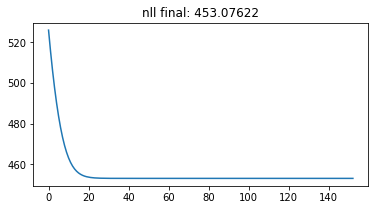

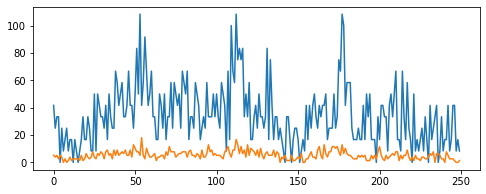

In [481]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.004
jitter_window_width = 0.02
basis_type = 'B1'

jittertool.bivariate_spike_hist_coupling_filter_regression(
    spike_times_sync_x, spike_times_sync_y, basis_type=basis_type,
    trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-12)

#### Regression Closed form solution.
The difference between closed form and the regression is that some x_i contains more than 1 spikes. This problem is less sever when the spike bin is very small.

In [877]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.004
jitter_window_width = 0.02
link_func = 'linear'

beta_supp = jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length, spk_bin_width=spk_bin_width, 
    link_func=link_func, basis_type='B1_binary')

beta_cnt = jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
    spike_times_sync_x, spike_times_sync_y,  trial_length=trial_length, spk_bin_width=spk_bin_width, 
    link_func=link_func, basis_type='B1_cnt')

print(beta_supp)
print(beta_cnt)

0.33557724671827666
0.40642881184786267


### Comparison between regression, closed form binary estimation, and spike cnt.

In [878]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(11)

num_iters = 15
trial_length = 2
lmbd_0 = 30
lmbd_1 = 30
num_trials = 30

link_func = 'linear'
spk_bin_width = 0.002
jitter_window_width = 0.02

firing_rate = np.zeros(num_iters)
betas = np.zeros((num_iters, 3))

lmbds = np.linspace(10, 100, num_iters)
for itr, lmbd in enumerate(lmbds):   
    lmbd_0, lmbd_1 = lmbd, lmbd
        
    spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials=num_trials)
    spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials=num_trials)
    synchrony_rate = 0.5
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)
    
    # Regression.
    basis_type = 'B1'
    beta_regression = jittertool.bivariate_spike_hist_coupling_filter_regression(
        spike_times_sync_x, spike_times_sync_y, basis_type=basis_type, link_func=link_func,
        trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-12)
    # Regression.
    basis_type = 'B1_binary'
    beta_binary = jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
        spike_times_sync_x, spike_times_sync_y, link_func=link_func,
        trial_length=trial_length, spk_bin_width=spk_bin_width, basis_type=basis_type)
    # Regression.
    basis_type = 'B1_cnt'
    beta_cnt = jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
        spike_times_sync_x, spike_times_sync_y, link_func=link_func,
        trial_length=trial_length, spk_bin_width=spk_bin_width, basis_type=basis_type)

    firing_rate[itr] = lmbd
    betas[itr] = [beta_regression, beta_binary, beta_cnt]
    
#     print(beta_regression[0,0])
#     print(beta_binary)
#     print(beta_cnt)

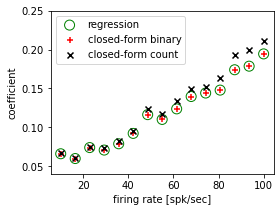

In [879]:
plt.figure(figsize=[4, 3])
plt.scatter(firing_rate,  betas[:,0], marker='o', s=100, facecolor='none', edgecolor='g', label='regression')
plt.scatter(firing_rate,  betas[:,1], marker='+', color='r', label='closed-form binary')
plt.scatter(firing_rate,  betas[:,2], marker='x', color='k', label='closed-form count')
plt.ylim(0.04, 0.25)
plt.xlabel('firing rate [spk/sec]')
plt.ylabel('coefficient')
plt.legend()

plt.show()

#### log-lambda regression

In [ ]:
# Spike basis.
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'exp'

jittertool.bivariate_spike_hist_coupling_filter_regression(
    spike_times_sync_x, spike_times_sync_y, link_func=link_func,
    trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-14)

num iterations:  18
[[ 1.26461614]
 [-0.41364553]]
overall mean FR: 34.87
estimat mean FR: 274.13


D:/Brain_Network/Code\jitter.py:1578: RuntimeWarning: divide by zero encountered in log
  spike_hist_x_conv = np.log(spike_hist_x_conv).reshape(-1)


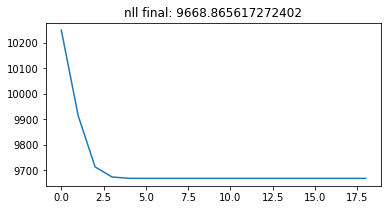

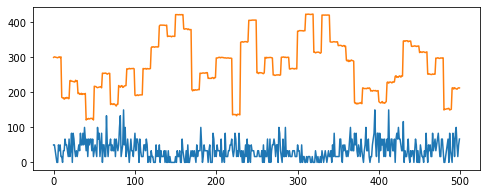

In [342]:
# Convolve basis.
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'exp'

jittertool.bivariate_spike_hist_coupling_filter_regression(
    spike_times_sync_x, spike_times_sync_y, link_func=link_func,
    trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-14)

#### log regression estimation.

In [323]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'exp'

jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
    spike_times_sync_x, spike_times_sync_y, link_func=link_func,
    trial_length=trial_length, spk_bin_width=spk_bin_width)

-3.3180064486699115

# Regression coefficient distribuions

#### MC regression binarized spike train.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 281.51it/s]


p-val: 7.493e-01
beta_raw 0.03622497616777884
beta_mean 0.04055424213536702


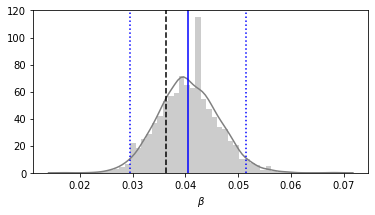

In [1081]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='mc'
num_jitter=5000

binarize=False
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, num_jitter=num_jitter, 
    ci_alpha=0.05, binarize=binarize, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 270.40it/s]


p-val: 7.632e-01
beta_raw 0.034318398474737846
beta_mean 0.039413727359389895
beta_CI_down 0.029551954242135366
beta_CI_up 0.05147759771210677


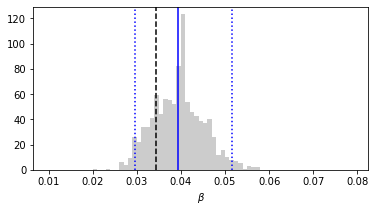

In [1135]:
np.random.seed(1)
distribution_type='mc'
binarize=True
num_jitter=1000
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, num_jitter=num_jitter,
    ci_alpha=0.05, binarize=binarize, verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.61it/s]


p-val: 8.132e-01
beta_raw 0.03431842812764275
beta_mean 0.03941375255924668
beta_CI_down 0.02955198913905317
beta_CI_up 0.05147757813248986


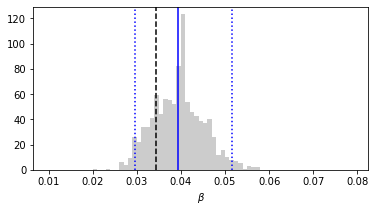

In [1136]:
np.random.seed(1)
distribution_type='mc'
calculation_type = 'optimize'
num_jitter=1000
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length,
    jitter_window_width=jitter_window_width, distribution_type=distribution_type,
    calculation_type=calculation_type, num_jitter=num_jitter, ci_alpha=0.05, verbose=True)

# Binom distribution binarized vs count trains.

#### Debugging binary regression tools.

jittertool = jitter.JitterTool()
x = jittertool.num_set_nonempty_partitions(3, 1); print(x)
x = jittertool.num_set_nonempty_partitions(3, 2); print(x)
x = jittertool.num_set_nonempty_partitions(3, 3); print(x)
x = jittertool.num_set_nonempty_partitions(4, 2); print(x)
x = jittertool.num_set_nonempty_partitions(4, 3); print(x)
x = jittertool.num_set_nonempty_partitions(5, 3); print(x)

In [674]:
jittertool = jitter.JitterTool()
# Check true results in the function string doc.
pmf = jittertool.binaried_pmf_single(2, 4, 2); print(pmf, pmf.sum())
pmf = jittertool.binaried_pmf_single(2, 5, 2); print(pmf, pmf.sum())
pmf = jittertool.binaried_pmf_single(2, 4, 3); print(pmf, pmf.sum())
pmf = jittertool.binaried_pmf_single(3, 4, 2); print(pmf, pmf.sum())

[0.25  0.625 0.125] 1.0
[0.36 0.56 0.08] 1.0
[0.125   0.59375 0.28125] 1.0
[0.0625 0.5625 0.375 ] 1.0


#### Regression closed form using binary.

p-val: 7.948e-01
beta_raw 0.03622497616777884
beta_mean 0.04051477597694403


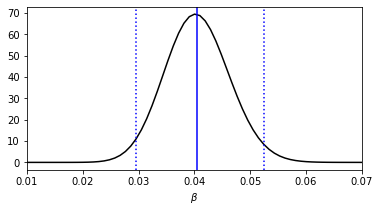

p-val: 8.445e-01
beta_raw 0.034318398474737846
beta_mean 0.03943594852227394


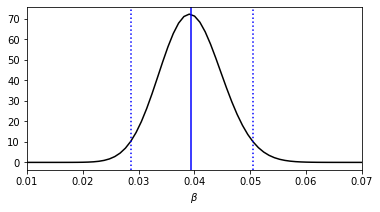

In [706]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='binom'
mean_correct_type = None

binarize=False
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length,
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, mean_correct_type=mean_correct_type, 
    binarize=binarize, ci_alpha=0.05, verbose=True)

binarize=True
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length,
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, mean_correct_type=mean_correct_type, 
    binarize=binarize, ci_alpha=0.05, verbose=True)

#### Mean estimation.

In [861]:
mean_type='cnt'
beta_mean = jittertool.bivariate_spike_hist_coupling_filter_regression_closed_mean(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length,
    jitter_window_width=jitter_window_width, spk_bin_width=spk_bin_width, mean_type=mean_type, verbose=True)

mean_type='binary'
beta_mean = jittertool.bivariate_spike_hist_coupling_filter_regression_closed_mean(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length,
    jitter_window_width=jitter_window_width, spk_bin_width=spk_bin_width, mean_type=mean_type, verbose=True)


beta mean 0.19597778525748902
beta mean 0.17824746333271613


#### Mean correction.

p-val: 9.268e-02
beta_raw 0.008262910798122067
beta_mean -1.5934331626518347e-13


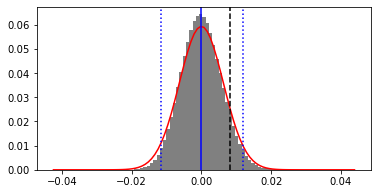

In [394]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0.2
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='binom'
mean_correct_type = 'cnt'
binarize=False

p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length,
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, mean_correct_type=mean_correct_type, 
    binarize=binarize, ci_alpha=0.05, verbose=True)


#### Baseline correction.

In [718]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02
link_func = 'linear'

jittertool.bivariate_spike_hist_coupling_filter_regression(
    spike_times_sync_x, spike_times_sync_y, link_func=link_func, 
    trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-12)

array([[ 0.31846657],
       [-0.00197467]])

#### Poisson approximation.

p-val: 8.597e-01
beta_raw 0.034318398474737846
beta_mean 0.04051477597712107


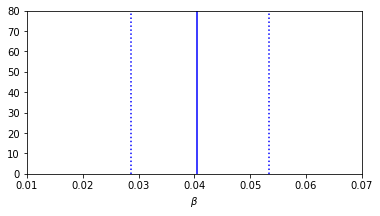

In [717]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='poisson'

p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, ci_alpha=0.05, verbose=True)

## jitter regression p-vals

#### MC p-value distribution.

In [240]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)

num_iters = 1000
trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

p_vals_list = np.zeros(num_iters)

for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]
    synchrony_rate = 0
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    spk_bin_width = 0.002
    jitter_window_width = 0.02
    distribution_type='mc'
    num_jitter=300

    _, _, _, p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
        jitter_window_width=jitter_window_width, distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.01)

In [ ]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02)

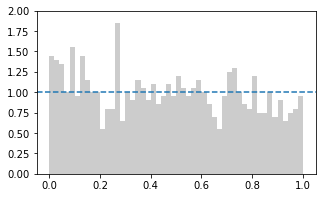

In [241]:
# synchrony_rate = 0.0

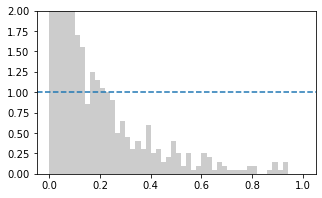

In [233]:
# synchrony_rate = 0.2

#### Binom exact inference

In [263]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)

num_iters = 500
trial_length = 2
num_trials = 30
num_peaks, sigma = 25, 0.03

p_vals_list = np.zeros(num_iters)
for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]
    synchrony_rate = 0
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    spk_bin_width = 0.002
    jitter_window_width = 0.02
    distribution_type = 'binom'

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
        jitter_window_width=jitter_window_width, distribution_type=distribution_type)

In [ ]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02)

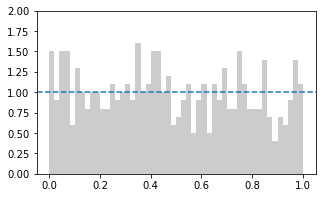

In [264]:
# sync rate = 0

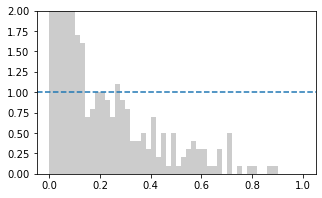

#### Poisson approximate

In [289]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)

num_iters = 500
trial_length = 2
num_trials = 30
num_peaks, sigma = 25, 0.03

p_vals_list = np.zeros(num_iters)
for r in trange(num_iters):
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]
    synchrony_rate = 0.2
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    spk_bin_width = 0.002
    jitter_window_width = 0.02
    distribution_type = 'poisson'

    p_vals_list[r] = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
        jitter_window_width=jitter_window_width, distribution_type=distribution_type)

In [ ]:
jittertool.plot_p_value_distribution([p_vals_list], bin_width=0.02)

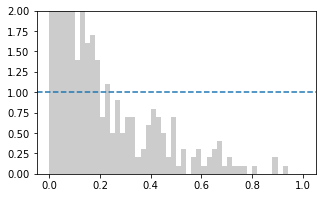

In [290]:
# sync rate = 0.2

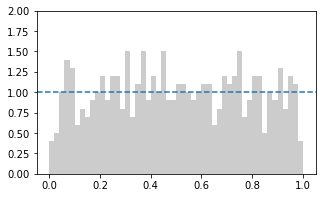

In [288]:
# sync rate = 0

# Jitter regression mean correction.

In [178]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
# np.random.seed(1)
trial_length = 1
num_peaks = 25
num_trials = 30
sigma = 0.04
spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]

synchrony_rate = 1
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)


#### Basis regression.

num iterations:  251
[[0.09255898]]
overall mean FR: 36.37
estimat mean FR: 3.40


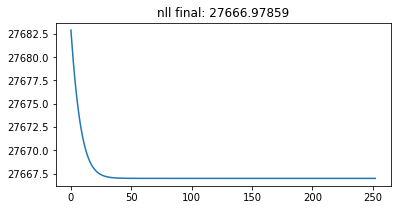

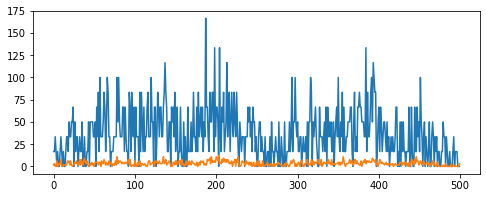

In [179]:
jittertool = jitter.JitterTool()
spk_bin_width = 0.002
jittertool.bivariate_spike_hist_coupling_filter_regression(
    spike_times_sync_x, spike_times_sync_y,
    trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-12)

p-val: 1.090e-02
0.09891107078039928


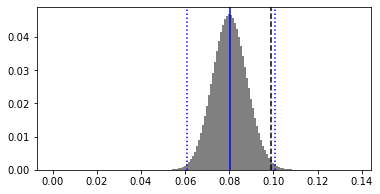

In [180]:
spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='binom'

p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length,
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, ci_alpha=0.01, verbose=True)

### Mean beta estimation NOT from mean basis regression

since in the linear model, $\lambda = x \beta$, the likelihood is
$$NLL = \sum_i \Big( - y_i \log x_i \beta +  x_i \beta \Big)$$
So it is NOT a linear funciton of x.

In [181]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02

jittertool.bivariate_spike_hist_coupling_filter_regression_closed_mean(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length,
    jitter_window_width=jitter_window_width, spk_bin_width=spk_bin_width)

0.08030852994555356

X_original.shape (30000, 1)
X.shape (25900, 1)
num iterations:  126


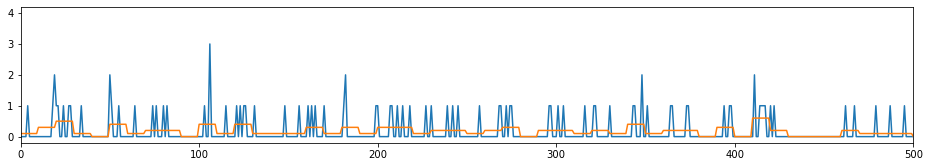

overall mean FR: 98.83
estimat mean FR: 85.35


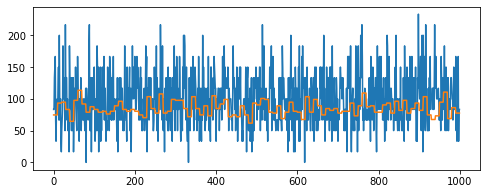

array([[0.86183103]])

In [888]:
jittertool = jitter.JitterTool()

spk_bin_width = 0.002
jitter_window_width = 0.02
jitter_type = 'interval'
basis_type = 'B0'
link_func = 'linear'

jittertool.bivariate_spike_hist_coupling_filter_regression(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length, spk_bin_width=spk_bin_width, 
    jitter_window_width=jitter_window_width, jitter_type=jitter_type, link_func=link_func, 
    basis_type=basis_type, epsilon=1e-10, verbose=True)

### Mean-beta offset correction.

#### MC regression (closed).

100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 280.91it/s]


p-val: 7.246e-01
beta_raw -0.004289799809342229
beta_mean -0.00021544327931363174
beta_CI_down -0.010009532888465206
beta_CI_up 0.010962821734985702


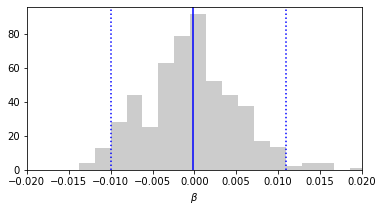

100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 277.78it/s]


p-val: 7.904e-01
beta_raw -0.006196377502383221
beta_mean -0.0011458531935176356
beta_CI_down -0.011916110581506194
beta_CI_up 0.010009532888465206


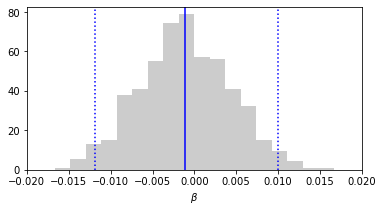

100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 271.23it/s]


p-val: 7.964e-01
beta_raw -0.005117550047664433
beta_mean -0.00024243088655861894
beta_CI_down -0.010837283126787407
beta_CI_up 0.009682259294566242


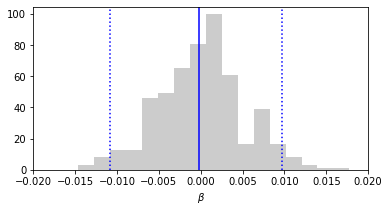

100%|████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 265.56it/s]


p-val: 8.144e-01
beta_raw -0.005117550047664433
beta_mean 7.97807435653086e-05
beta_CI_down -0.009883994280266914
beta_CI_up 0.010135071496663497


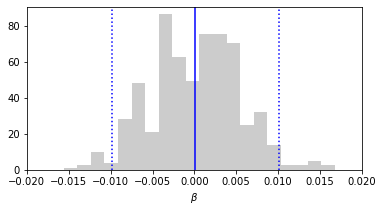

In [1258]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='mc'
num_jitter=500

mean_correct_type = 'cnt'
binarize=False
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length, jitter_window_width,
    distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    num_jitter=num_jitter, binarize=binarize, ci_alpha=0.05, verbose=True)

mean_correct_type = 'cnt'
binarize=True
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length, jitter_window_width,
    distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    num_jitter=num_jitter, binarize=binarize, ci_alpha=0.05, verbose=True)

mean_correct_type = 'binary'
binarize=False
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length, jitter_window_width, 
    distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    num_jitter=num_jitter, ci_alpha=0.05, verbose=True)

mean_correct_type = 'binary'
binarize=True
p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length, jitter_window_width, 
    distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    num_jitter=num_jitter, ci_alpha=0.05, verbose=True)


#### MC regression (optimize)

In [1276]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='mc'
num_jitter=5000
binarize=True
mean_correct_type = 'binary'
calculation_type = 'optimize'
p_val, _, = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length, jitter_window_width, 
    distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    num_jitter=num_jitter, calculation_type=calculation_type, ci_alpha=0.05, verbose=True)

100%|███████████████████████████████████████████████████████████| 5000/5000 [13:01<00:00,  6.40it/s]


#### Binom (closed)

p-val: 8.445e-01
beta_raw -0.005117550047664433
beta_mean -1.2834009435703717e-13
beta_CI_down -0.010837283126787407
beta_CI_up 0.011088360343183994


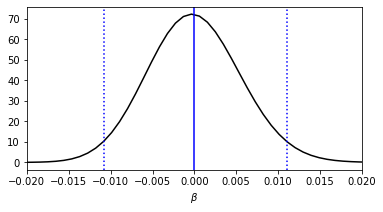

In [1282]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='binom'
mean_correct_type = 'binary'
binarize = True

p_val, _ = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    binarize=binarize, ci_alpha=0.05, verbose=True)

###### (tmp) Distribution comparison, regression with baseline correction v.s. binom binary.
Need to let the function bivariate_spike_hist_coupling_filter_regression_jitter return jitter_beta and pmf_x, pmf.
These are temporary returns, need to modify the code.

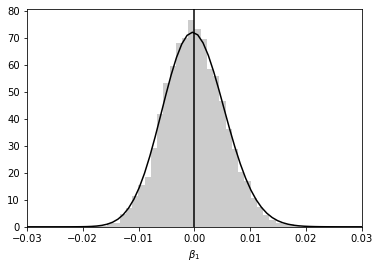

In [1279]:
seaborn.distplot(beta_jitter, bins=41, color='grey', kde=False, norm_hist=True)
plt.plot(pmf_x, pmf/(pmf_x[1]-pmf_x[0]), color='k')

beta_mean = np.mean(beta_jitter)
plt.axvline(x=beta_mean, c='k')
plt.xlim([-0.03, 0.03])
# plt.ylim([0, 80])
plt.xlabel(r'$\beta_1$')
plt.show()

#### Binom (optimize for the test statistic, distribution from binom)

p-val: 6.199e-01
beta_raw -0.001777203176177902
beta_mean -1.2834009435703717e-13
beta_CI_down -0.010837283126787407
beta_CI_up 0.011088360343183994


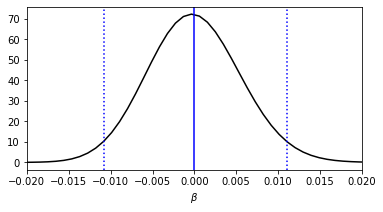

In [1259]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='binom'
mean_correct_type = 'binary'
binarize = True
calculation_type = 'optimize'

p_val, _ = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length, jitter_window_width,
    distribution_type=distribution_type, calculation_type=calculation_type,
    mean_correct_type=mean_correct_type, binarize=binarize, ci_alpha=0.05, verbose=True)

#### Poisson

p-val: 1.000e+00
beta_raw -0.005117550047664433
beta_mean 0.0010788274547187879
beta_CI_down -0.010837283126787407
beta_CI_up 0.013948226882745482


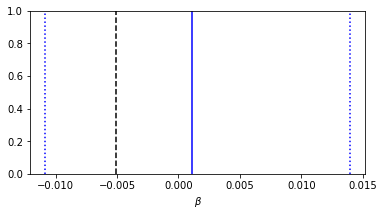

In [1149]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='poisson'
mean_correct_type = 'binary'
binarize = True

p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    binarize=binarize, ci_alpha=0.05, verbose=True)

# Comparison between $\beta$ mean removal. <a name='beta_mean_removal'></a>

### Compare $\beta_0$ estimation. 

In [919]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

num_iters = 15
trial_length = 2
lmbd_0 = 30
lmbd_1 = 30
num_trials = 30

spk_bin_width = 0.002
jitter_window_width = 0.02

firing_rate = np.zeros(num_iters)
beta0 = np.zeros((num_iters, 2))

lmbds = np.linspace(10, 100, num_iters)
for itr, lmbd in enumerate(lmbds):   
    lmbd_0, lmbd_1 = lmbd, lmbd
        
    spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials=num_trials)
    spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials=num_trials)
    synchrony_rate = 2
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    # Regression optimization.
    link_func = 'linear'
    basis_type = 'B0'
    jitter_type = 'interval'
    beta0_regression = jittertool.bivariate_spike_hist_coupling_filter_regression(
        spike_times_sync_x, spike_times_sync_y, basis_type=basis_type, link_func=link_func, jitter_type=jitter_type,
        trial_length=trial_length, spk_bin_width=spk_bin_width, jitter_window_width=jitter_window_width, epsilon=1e-12)

    # Closed form.
    link_func = 'linear'
    basis_type = 'B0'
    beta0_closed = jittertool.bivariate_spike_hist_coupling_filter_regression_closed(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length, spk_bin_width=spk_bin_width, 
    jitter_window_width=jitter_window_width, link_func=link_func, basis_type=basis_type)

    firing_rate[itr] = lmbd
    beta0[itr] = [beta0_regression, beta0_closed]


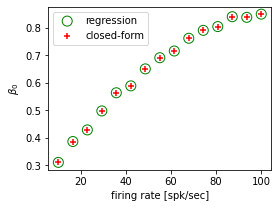

In [920]:
plt.figure(figsize=[4, 3])
plt.scatter(firing_rate,  beta0[:,0], marker='o', s=100, facecolor='none', edgecolor='g', label='regression')
plt.scatter(firing_rate,  beta0[:,1], marker='+', color='r', label='closed-form')
# plt.ylim(0.04, 0.25)
plt.xlabel('firing rate [spk/sec]')
plt.ylabel(r'$\beta_0$')
plt.legend()

plt.show()


#### Compare mean beta.

In [1283]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(2)

num_iters = 50
num_peaks = 10
lmbd_0, lmbd_1 = 20, 20
synchrony_rate = 0
trial_length = 2
num_trials = 30
sigma = 0.04

beta_mean = np.zeros([num_iters, 2])

for itr in trange(num_iters):
    # Laplace.
#     num_peaks = np.random.randint(10, 80)
#     synchrony_rate = np.random.rand() * 0.4 + 0.05
#     spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
#             trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
#     spike_times_x = spike_times[:num_trials]
#     spike_times_y = spike_times[num_trials:]   
    # Poisson.
    spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials=num_trials)
    spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials=num_trials)

    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    spk_bin_width = 0.002
    jitter_window_width = 0.02
    link_func = 'linear'
    distribution_type='binom'
    mean_type = 'binary'
    beta_mean[itr, 0] = jittertool.bivariate_spike_hist_coupling_filter_regression_closed_mean(
    spike_times_sync_x, spike_times_sync_y, trial_length=trial_length,
    jitter_window_width=jitter_window_width, spk_bin_width=spk_bin_width, mean_type=mean_type, verbose=False)

    jitter_type = 'interval'
    basis_type = 'B0'
    beta_tmp = jittertool.bivariate_spike_hist_coupling_filter_regression(
        spike_times_sync_x, spike_times_sync_y, link_func=link_func, basis_type=basis_type,
        jitter_type=jitter_type, trial_length=trial_length, spk_bin_width=spk_bin_width, 
        jitter_window_width=jitter_window_width, epsilon=1e-9)
    beta_mean[itr, 1] = beta_tmp[0,0]


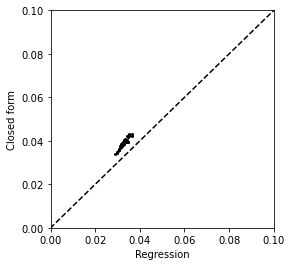

In [1284]:
beta_mean_adj_regression = beta_mean[:, 1] / 10

plt.figure(figsize=(4, 4))

plt.plot([-0.1, 0.5], [-0.1, 0.5], 'k--')
plt.plot(beta_mean_adj_regression, beta_mean[:, 0], 'k.', ms=4)

plt.axis([-0.0, 0.1, -0.0, 0.1])
plt.xlabel('Regression')
plt.ylabel('Closed form')
plt.show()

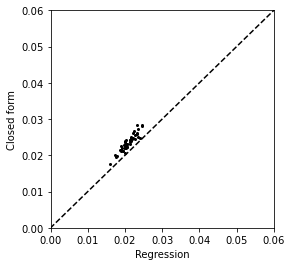

In [948]:
# num_peaks = 10 synchrony_rate = 0

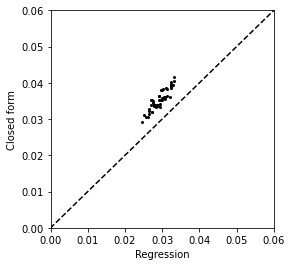

In [944]:
# num_peaks = 20 synchrony_rate = 0

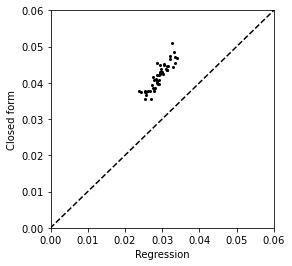

In [942]:
# num_peaks = 20 synchrony_rate = 0.8

#### Compare beta after mean removal

In [1251]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(2)

num_iters = 200
num_peaks = 10
synchrony_rate = 0.1
trial_length = 2
num_trials = 30
sigma = 0.04

beta = np.zeros([num_iters, 2])

for itr in tqdm(range(num_iters), ncols=100):
    num_peaks = np.random.randint(5, 50)
    synchrony_rate = np.random.rand() * 0.8
    spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
            trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
    spike_times_x = spike_times[:num_trials]
    spike_times_y = spike_times[num_trials:]   
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    spk_bin_width = 0.002
    jitter_window_width = 0.02
    link_func = 'linear'
    distribution_type='binom'
    binarize = True
    mean_correct_type = 'binary'

    _, beta[itr, 0] = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
        spike_times_sync_x, spike_times_sync_y, spk_bin_width=spk_bin_width, trial_length=trial_length, 
        jitter_window_width=jitter_window_width, distribution_type=distribution_type, mean_correct_type=mean_correct_type,
        binarize=binarize, ci_alpha=0.05, verbose=False)

    jitter_type = 'interval_binary'
    basis_type = 'B0B1'
    beta_tmp = jittertool.bivariate_spike_hist_coupling_filter_regression(
        spike_times_sync_x, spike_times_sync_y, link_func=link_func, basis_type=basis_type,
        jitter_type=jitter_type, trial_length=trial_length, spk_bin_width=spk_bin_width,
        jitter_window_width=jitter_window_width, epsilon=1e-9)
    delta = int(jitter_window_width / spk_bin_width)
    beta[itr, 1] = beta_tmp[1,0] * (delta-1) / delta


100%|█████████████████████████████████████████████████████████████| 200/200 [02:41<00:00,  1.24it/s]


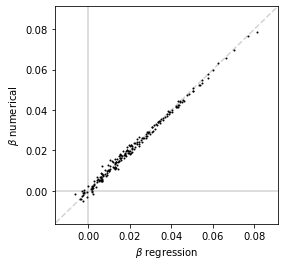

In [1252]:
plt.figure(figsize=(4, 4))
plt.axvline(x=0, c='lightgrey')
plt.axhline(y=0, c='lightgrey')
plt.plot([-1, 1], [-1, 1], ls='--', c='lightgrey')

plt.plot(beta[:,1], beta[:,0], 'k.', ms=2)
val_min = np.min(beta)
val_max = np.max(beta)
margin = 0.01
plt.axis([val_min-margin, val_max+margin, val_min-margin, val_max+margin])
plt.xlabel(r'$\beta$ regression')
plt.ylabel(r'$\beta$ numerical')
plt.show()

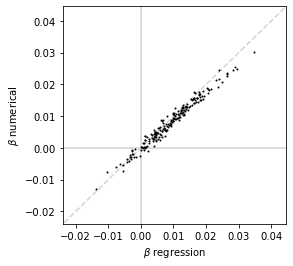

In [1246]:
# Without bias correction.

# Regression with baseline correction.

p-val: 8.445e-01
beta_raw -0.005117550047664433
beta_mean -1.2834009435703717e-13


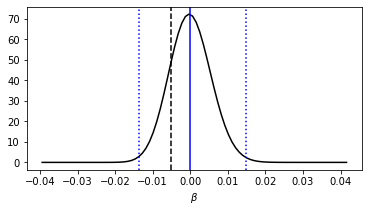

In [1079]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(1)

trial_length = 2
num_peaks = 25
num_trials = 30
sigma = 0.04

spike_times = generator.generate_amarasingham_example_spike_times(num_peaks=num_peaks, sigma=sigma,
        trial_length=trial_length, num_trials=num_trials*2, sample_type='density', verbose=False)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]
synchrony_rate = 0
spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
    spike_times_x, spike_times_y, synchrony_rate, trial_length)

spk_bin_width = 0.002
jitter_window_width = 0.02
distribution_type='binom'
mean_correct_type = 'binary'
binarize = True

p_val = jittertool.bivariate_spike_hist_coupling_filter_regression_jitter(
    spike_times_sync_x, spike_times_sync_y, spk_bin_width, trial_length,  jitter_window_width,
    distribution_type=distribution_type, mean_correct_type=mean_correct_type,
    binarize=binarize, verbose=True)

# Models comparison <a name='models_comp'>

In [1225]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
jittertool = jitter.JitterTool()
np.random.seed(1)

num_neg = 150
num_pos = 150

trial_length = 2
num_trials = 25
jitter_window_width = 0.02
spk_bin_width = 0.002

scores_h0, scores_h1 = [0]*num_neg, [0]*num_pos
# H0 distribution.
for r in tqdm(range(num_neg), ncols=100):
    synchrony_rate_0 = 0
#     lmbd_0, lmbd_1 = 20, 20
#     spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials=num_trials)
#     spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials=num_trials)
    num_peaks, sigma = 25, 0.04
    spike_times = generator.generate_amarasingham_example_spike_times(
        num_peaks, sigma, trial_length, num_trials*2, sample_type='density', verbose=False)
    spike_times_x, spike_times_y = spike_times[:num_trials], spike_times[num_trials:]
    
    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate_0, trial_length)

    scores_h0[r] = jittertool.models_comparision(spike_times_sync_x, spike_times_sync_y, trial_length=trial_length, 
        jitter_window_width=jitter_window_width, spk_bin_width=spk_bin_width)

# H1 distribution.
for r in tqdm(range(num_pos), ncols=100):
    synchrony_rate = 0.4
#     lmbd_0, lmbd_1 = 20, 20
#     spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials=num_trials)
#     spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials=num_trials)
    num_peaks, sigma = 25, 0.04
    spike_times = generator.generate_amarasingham_example_spike_times(
        num_peaks, sigma, trial_length, num_trials*2, sample_type='density', verbose=False)
    spike_times_x, spike_times_y = spike_times[:num_trials], spike_times[num_trials:]

    spike_times_sync_x, spike_times_sync_y = generator.inject_synchrony_to_spike_times(
        spike_times_x, spike_times_y, synchrony_rate, trial_length)

    scores_h1[r] = jittertool.models_comparision(spike_times_sync_x, spike_times_sync_y, trial_length=trial_length,
        jitter_window_width=jitter_window_width, spk_bin_width=spk_bin_width)

100%|█████████████████████████████████████████████████████████████| 150/150 [02:15<00:00,  1.10it/s]


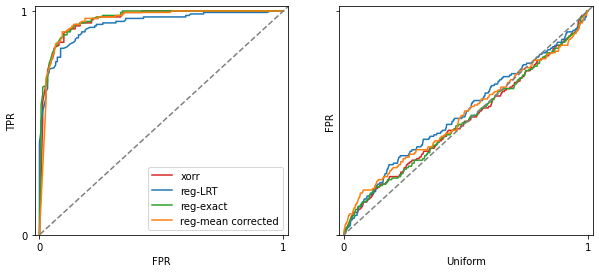

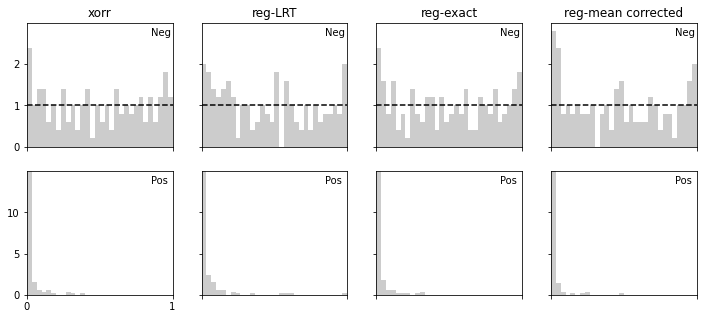

In [1226]:
jittertool.roc(neg_scores=scores_h0, pos_scores=scores_h1, verbose=True)

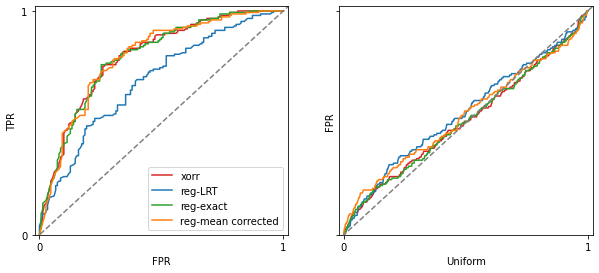

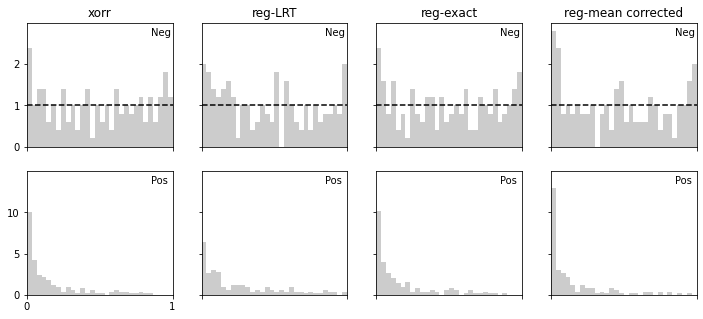